In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.io import loadmat
from sklearn.cluster import KMeans
from scipy.linalg import svd
# some settings

import matplotlib as mpl
import matplotlib.image as mpimg
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## k-means clustering

0. Initialize centroids

loop until convergence:
    1. Find closest centroids
    2. Compute centroid means and reassign

In [2]:
data = loadmat('res/ex7data2.mat')

In [3]:
data1= data['X']

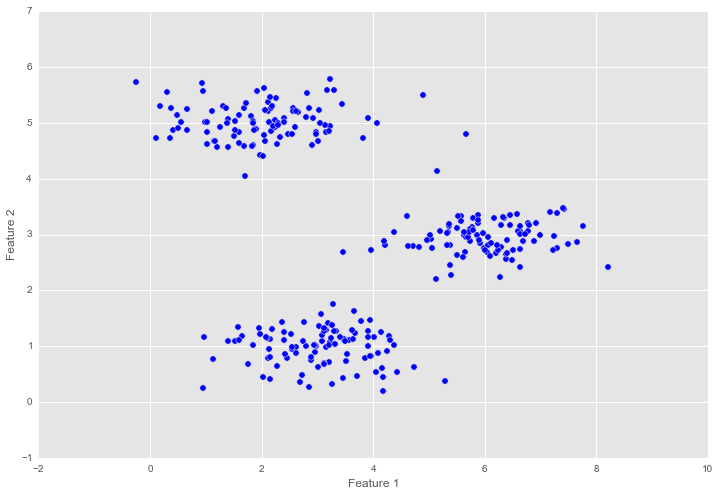

In [35]:
plt.scatter(data1[:,0], data1[:,1],s=40)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

In [21]:
def kMeansInitCentroids(X,K):
    (m,n) = X.shape
    centroids = np.zeros((K,n))
    # randomly permute
    randidx = np.random.permutation(np.arange(X.shape[0]))
    # select first K
    centroids = X[randidx[0:K], :]  
    return centroids

In [22]:
def findClosestCentroids(X, centroids): 
    m, n = X.shape
    K = centroids.shape[0]
    idx = np.zeros(m)
    dist = np.zeros(K)
    for i in np.arange(m):
        for j in np.arange(K):
            dist[j] = np.sum (np.square(X[i,:]- centroids[j,:]))
        idx[i] = np.argmin(dist)
    return idx

In [23]:
def computeCentroids(X, idx, K):
    (m,n) = X.shape
    centroids = np.zeros((K,n))
    for k in np.arange(K):
        subset = X[idx==k,:]
        centroids[k,:] = np.sum(subset,axis=0)/ subset.shape[0] 
    return centroids

In [8]:
def runKmeans(X, initial_centroids, max_iters):
    (m,n) = X.shape
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids
    idx = np.zeros(m)
    for i in np.arange(max_iters):
        idx = findClosestCentroids(X, centroids)
        centroids = computeCentroids(X, idx, K)
    return centroids, idx

This is not a very efficient implementation, as it is using Python loops.

In [24]:
X = np.c_[data1[:,0],data1[:,1]]

In [25]:
initial_centroids = kMeansInitCentroids(X, 3)

In [26]:
centroids, idx = runKmeans(X, initial_centroids, max_iters = 10)

In [28]:
print centroids
print idx

[[ 3.04367119  1.01541041]
 [ 6.03366736  3.00052511]
 [ 1.95399466  5.02557006]]
[ 2.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  1.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  

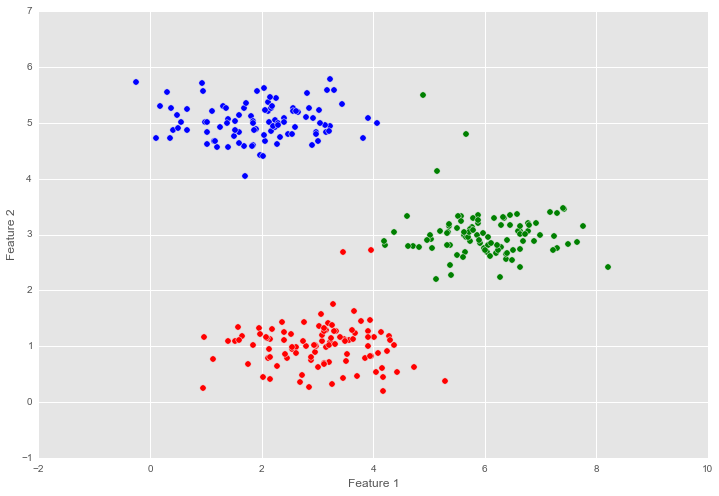

In [29]:
plt.scatter(X[:,0][idx==1],X[:,1][idx==1], c= 'g',s=40)
plt.scatter(X[:,0][idx==0],X[:,1][idx==0], c= 'r',s=40)
plt.scatter(X[:,0][idx==2],X[:,1][idx==2], c= 'b',s=40)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# k-means for image compression

In [32]:
img = mpimg.imread('res/bird_small.png')

In [15]:
img = img.reshape(img.shape[0]*img.shape[1],3)

In [16]:
# my implementation is way too slow, and it didn't seem to work
km = KMeans()
km.fit(img,16)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=8, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [33]:
im_reconst = km.cluster_centers_[km.labels_].reshape(128, 128, 3)

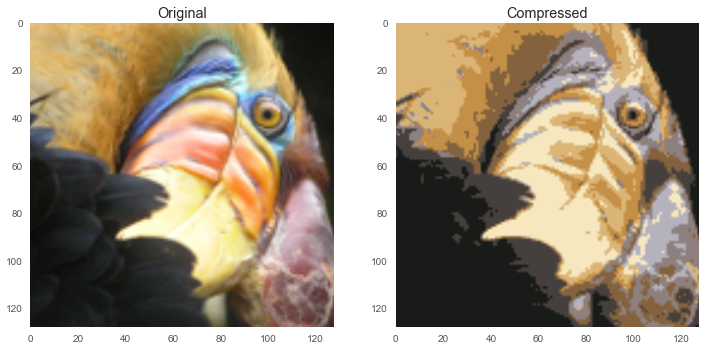

In [34]:
plt.subplot(1,2,1)
plt.grid(False)
plt.imshow(img)
plt.title('Original')
plt.subplot(1,2,2)
plt.grid(False)
plt.imshow(im_reconst)
plt.title('Compressed')

# Principal component analysis

`"Before using PCA, it is important to first normalize the data by subtracting the mean value of each feature from the dataset, and scaling each dimension so that they are in the same range"`

* Compute covariance matrix
* Use SVD to extract eigen vectors

In [64]:
def featureNormalize(X):
    mu = np.mean(X,axis=0)
    sigma = np.std(X,axis=0)
    X_norm = (X- mu)/sigma
    return X_norm, mu

In [65]:
def pca(X):
    m,n = X.shape
    U = np.zeros(n)
    S = np.zeros(n)
    Sigma = X.T.dot(X)/m
    U, S, V = svd(Sigma)
    return U, S

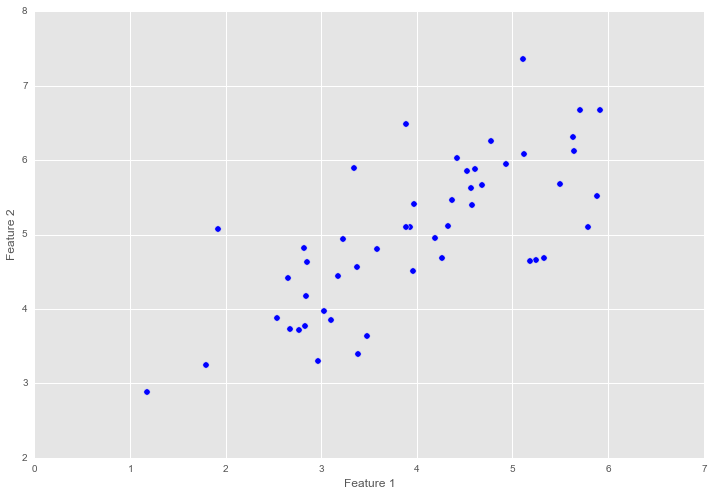

In [66]:
mat = loadmat('res/ex7data1.mat')
data2 = mat['X']
plt.scatter(data2[:,0], data2[:,1],s=40)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

In [67]:
X_norm,mu = featureNormalize(X)
U, S = pca(X_norm)

` U will contain the principal components and S will contain a diagonal matrix.`

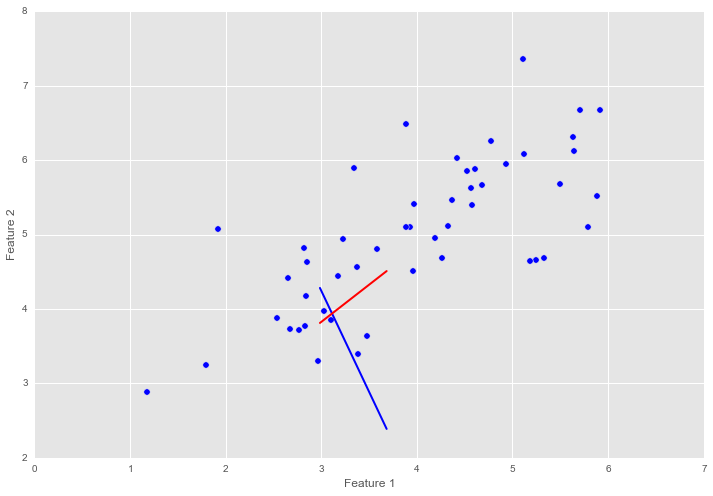

In [82]:
mat = loadmat('res/ex7data1.mat')
data2 = mat['X']
plt.scatter(data2[:,0], data2[:,1],s=40)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plot(mu,mu + 1.5 * S[0] * U[:,0], color='b', linestyle='-', linewidth=2)
plot(mu,mu + 1.5 * S[1] * U[:,1], color='r', linestyle='-', linewidth=2)

## Dimensionality reduction with PCA

`In practice, if you were using a learning algorithm such as linear regression or perhaps neural networks, you could now use the projected data instead of the original data. By using the projected data, you can train your model faster as there are less dimensions in the input.`

In [85]:
def projectData(X,U,K):    
    Z = np.zeros((X.shape[0],K))
    U_reduce = U[:,0:K]
    Z = X.dot(U_reduce)
    return Z

In [88]:
def recoverData(Z,U,K):
    X_rec = np.zeros((Z.shape[0],U.shape[0]))
    U_reduce = U[:,0:K]
    X_rec = Z.dot(U_reduce)
    return X_rec

In [95]:
K = 1
Z = projectData(X_norm, U, K)
# Z stores the projected data on 1 dimension

## PCA on the faces dataset

In [101]:
f = loadmat('res/ex7faces.mat')
faces = f['X']
print faces.shape

(5000L, 1024L)


In [130]:
faces = faces.reshape((5000,32,32))
#faces.transpose((0,2,1))
print faces.shape
print faces[0,:].shape

(5000L, 32L, 32L)
(32L, 32L)


In [151]:
def plot_gallery(images,h=32, w=32, n_row=10, n_col=10):
    plt.figure(figsize=(0.9 * n_col, 1.2 * n_row))
    #plt.subplots_adjust(bottom=0, left=.01, right=.02, top=.01, hspace=.01)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i,:], cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())

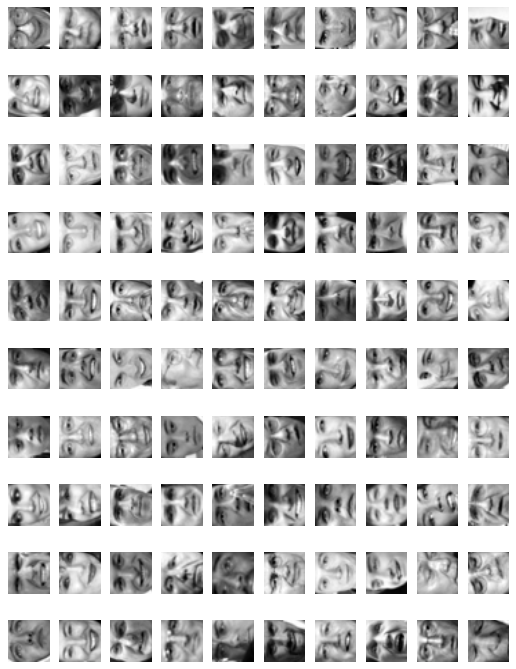

In [152]:
plot_gallery(faces)